# ChoiWu2021-QF-NoteOnMassZero

### Title: 
__A note on the option price and 'Mass at zero in the uncorrelated SABR model and implied volatility asymptotics'__

### Authors:
* Jaehyuk Choi ([@jaehyukchoi](https://github.com/jaehyukchoi))
* Lixin Wu

### Abstract:
Gulisashvili et al. [[Quant. Finance, 2018, 18(10), 1753-1765](https://doi.org/10.1080/14697688.2018.1432883)] provide a small-time asymptotics for the mass at zero under the uncorrelated SABR model by approximating the integrated variance with a moment-matched lognormal distribution. We improve the accuracy of the numerical integration by using the Gauss-Hermite quadrature. We further obtain the option price by integrating the CEV option prices in the same manner without resorting to the small-strike volatility smile asymptotics of De Marco et al. [[SIAM J. Financ. Math., 2017, 8(1), 709-737](https://epubs.siam.org/doi/abs/10.1137/14098065X)]. For the uncorrelated SABR model, the new method of option pricing is accurate and arbitrage-free across all strike prices.

### Links: 
[DOI](https://doi.org/10.1080/14697688.2021.1876908) | [arXiv](https://arxiv.org/abs/2011.00557) | [SSRN](http://ssrn.com/abstract=3709778). ([arXiv](http://arxiv.org/abs/2011.00557) is recommended for free download of the latest version.)

### Citation:
Choi, J., & Wu, L. (2021). A note on the option price and ‘Mass at zero in the uncorrelated SABR model and implied volatility asymptotics.’ Quantitative Finance (Forthcoming). https://doi.org/10.1080/14697688.2021.1876908 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy as sp

### Uncomment below if you want to run on your own modified code
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/pyfeng')
import pyfeng as pf

# Figure 1 left  and right (Figure 2 of GHJ 2018)

In [3]:
left = True

In [4]:
# Figure 1. (Figure 2 of GHJ 2018)
fwd = 0.03
sigma = 0.6
beta = 0.5 if left else 0.3
param = {'sigma': sigma, 'beta':beta, 'vov':1, 'rho':0.0}

tmax = 0.3 if left else 0.5

tarr_ln= np.arange(0.005, tmax+0.02, 0.01)
tarr_mc = np.arange(0, tmax+1e-6, 0.05)
tarr_mc[0] = 0.01

In [5]:
m_cev = pf.Cev(sigma=param['sigma'], beta=param['beta'])
m_sabr = pf.SabrUncorrChoiWu2021(**param)

mass = np.array([m_sabr.mass_zero(fwd, t) for t in tarr_ln])
m_sabr.n_quad = 100
mass_100 = np.array([m_sabr.mass_zero(fwd, t) for t in tarr_ln])
np.max(np.abs(mass - mass_100))

1.6444604244991723e-07

In [6]:
m_sabr.n_quad = 10  # change n_quad back to the defaut 10
mass0 = [m_sabr.mass_zero(fwd, t, log=True) for t in tarr_ln]

In [7]:
#### Monte-Carlo method not in pyfeng yet
m_mc = pf.SabrMcTimeDisc(**param)
m_mc.set_num_params(n_path=5e4, dt=0.05, rn_seed=123456)
mass1 = [m_mc.mass_zero(fwd, t, log=True, mu=0) for t in tarr_mc]

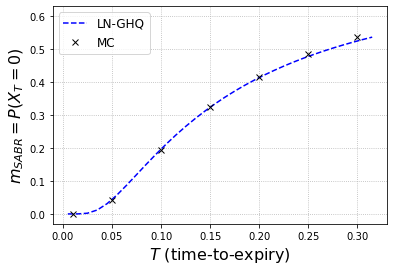

In [8]:
plt.plot(tarr_ln, np.exp(mass0), 'b--', label = 'LN-GHQ')
plt.plot(tarr_mc, np.exp(mass1), 'kx', label = 'MC')

if left:
    plt.ylim([-0.03, 0.63])
else:
    plt.ylim([-0.03, 1.03])

plt.ylabel(r'$m_{SABR}=P(X_T=0)$', fontsize=16)
plt.xlabel(r'$T$ (time-to-expiry)', fontsize=16)

plt.grid(linestyle=':')
plt.legend(fontsize=12)
#plt.savefig(f'../Latex-Etc/images/m0_GHJ18_beta{int(10*beta):0}.pdf', bbox_inches='tight')
#plt.savefig(f'../Latex-Etc/images/m0_GHJ18_beta{int(10*beta):0}.png', bbox_inches='tight')
plt.show()

# Figure 2 left 

In [9]:
param = {"sigma": 0.5, "vov": 0.4, "rho": 0.0, "beta":0.5}
fwd, texp = 0.5, 2
strike = np.power(10, np.arange(-2,1,0.1))*fwd

strike_exact = fwd * np.exp(0.1*np.sqrt(texp)*np.array([-1,0,1]))
p_exact = np.array([0.221383196830866, 0.193836689413803, 0.166240814653231])
vol_exact = pf.Bsm(None).impvol(p_exact, strike_exact, fwd, texp)*100

In [10]:
# Monte-Carlo
m = pf.SabrMcTimeDisc(**param)
m.set_num_params(n_path=5e4, dt=0.05, rn_seed=1234)
m0 = m.mass_zero(fwd, texp)
print(f'm_SABR = {m0:0.4f}')
vol_mc = m.vol_smile(strike, fwd, texp)*100

m_SABR = 0.1634


In [11]:
# LN-GHQ
m = pf.SabrUncorrChoiWu2021(**param)
m0 = m.mass_zero(fwd, texp)
print(f'm_SABR = {m0:0.4f}')
vol_ln = m.vol_smile(strike, fwd, texp)*100

m_SABR = 0.1657


In [12]:
# HKLW
vol_hklw = pf.SabrHagan2002(**param).vol_for_price(strike, fwd, texp)*100
# DMHJ 
strike_low = np.power(10, np.concatenate((np.arange(-2,0,0.05), np.arange(-0.05,0,0.005))))*fwd
vol_dmhj = m.vol_from_mass_zero(strike_low, fwd, texp)*100

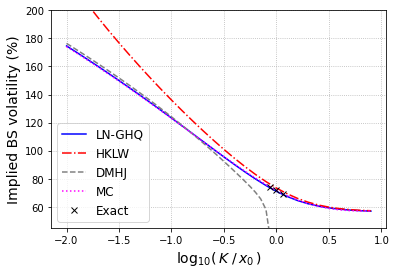

In [13]:
### Figure 2 Left

K_arr = [strike, strike, strike_low, strike]
vol_arr = [vol_ln, vol_hklw, vol_dmhj, vol_mc]
labels = ['LN-GHQ', 'HKLW', 'DMHJ', 'MC']

ls = ['-', '-.', '--', ':']
colors = ['b', 'r', 'gray', 'magenta']

for k in np.arange(4):  # use 4 to include MC
    plt.plot(np.log10(K_arr[k]/fwd), vol_arr[k], label=labels[k], color=colors[k], linestyle=ls[k])

plt.plot(np.log10(strike_exact/fwd), vol_exact, 'kx', label = 'Exact')

plt.ylim([45,200])
plt.ylabel('Implied BS volatility (%)', fontsize=14)
plt.xlabel(r'$\log_{10}(\, K\;/\,x_0\,)$', fontsize=14)
plt.legend(fontsize=12, loc=3)

plt.grid(linestyle=':')
#plt.savefig('../Latex-Etc/images/Set1-GHJ18.pdf', bbox_inches='tight')
#plt.savefig('../Latex-Etc/images/Set1-GHJ18.png', bbox_inches='tight')
plt.show()

# Figure 2 right: Cai et al Case III.C

In [14]:
param = {"sigma": 0.4, "vov": 0.6, "rho": 0, "beta":0.3}
fwd, texp = 0.05, 1

strike = np.power(10, np.arange(-2,1,0.1))*fwd

strike_exact = np.array([0.4, 0.8, 1, 1.2, 1.6, 2.0])*fwd
p_exact = np.array([0.0456, 0.0414, 0.0394, 0.0375, 0.0339, 0.0306])
vol_exact = pf.Bsm(None).impvol(p_exact, strike_exact, fwd, texp)*100

In [15]:
# Monte-Carlo
m = pf.SabrMcTimeDisc(**param)
m.set_num_params(n_path=5e4, dt=0.05, rn_seed=123456)
m0 = m.mass_zero(fwd, texp)
print(f'm_SABR = {m0:0.4f}')
vol_mc = m.vol_smile(strike, fwd, texp)*100

m_SABR = 0.7758


In [16]:
# LN-GHQ 
m = pf.SabrUncorrChoiWu2021(**param)
m0 = m.mass_zero(fwd, texp)
print(f'm_SABR = {m0:0.4f}')
vol_ln = m.vol_smile(strike, fwd, texp)*100

m_SABR = 0.7624


In [17]:
# HKLW
vol_hklw = pf.SabrHagan2002(**param).vol_for_price(strike, fwd, texp)*100
# DMHJ 
strike_low = np.power(10, np.concatenate((np.arange(-2,0,0.05), np.arange(-0.05,0,0.005))))*fwd
vol_dmhj = m.vol_from_mass_zero(strike_low, fwd, texp)*100

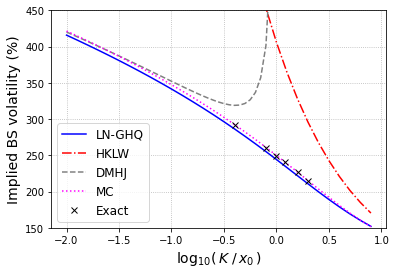

In [18]:
### Figure 2 Right

K_arr = [strike, strike, strike_low, strike]
vol_arr = [vol_ln, vol_hklw, vol_dmhj, vol_mc]
labels = ['LN-GHQ', 'HKLW', 'DMHJ', 'MC']

ls = ['-', '-.', '--', ':']
colors = ['b', 'r', 'gray', 'magenta']

for k in np.arange(4):  # use 4 to include MC
    plt.plot(np.log10(K_arr[k]/fwd), vol_arr[k], label=labels[k], color=colors[k], linestyle=ls[k])

plt.plot(np.log10(strike_exact/fwd), vol_exact, 'kx', label = 'Exact')

plt.ylim([150,450])
plt.ylabel('Implied BS volatility (%)', fontsize=14)
plt.xlabel(r'$\log_{10}(\, K\;/\,x_0\,)$', fontsize=14)
plt.legend(fontsize=12, loc=3)

plt.grid(linestyle=':')
#plt.savefig('../Latex-Etc/images/Set2-GHJ18.pdf', bbox_inches='tight')
#plt.savefig('../Latex-Etc/images/Set2-GHJ18.png', bbox_inches='tight')
plt.show()